In [222]:
import sqlite3
import pandas as pd
import os
import re
import numpy as np
from sklearn import cross_validation, metrics
from sklearn.metrics import accuracy_score, roc_curve, auc,  precision_recall_curve, average_precision_score
from sklearn.grid_search import GridSearchCV
from nltk.tokenize import sent_tokenize, word_tokenize, StanfordTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import string
import seaborn as sns
sns.set_style("whitegrid")
os.chdir('/Users/RayLJazz//Dropbox/UCDavis/2016spring/STA208/Github/Data')

# Read Pickles

In [104]:
SOM = pd.read_pickle('stackoverflow_metric_df.pickle')
RM = pd.read_pickle('Readability_Metrics_wtbody.pickle')
PM = pd.read_pickle('popularity_metric.pickle')

In [105]:
query = "SELECT * FROM [posts]"
conn = sqlite3.connect('crossvalidated.db')
post_df = pd.read_sql_query(query, conn)
post_df.head()
qpost_df = post_df[post_df.PostTypeId == 1]

## Stackoverflow Metrics

In [106]:
SOM.head()

,Id,ClosedDate,Score,BodyLen,LowerCasePer,UpperCasePer,SpaceCnt,TagCnt,Sentimental_Polarity,Sentimental_Subjectivity,TitleLen,UrlCnt
0,1,None,31,91,0.958763,0.041237,15,3,0.133333,0.133333,29,0
1,2,None,26,146,0.969466,0.030534,25,2,0.000000,0.000000,18,0
2,3,None,63,206,0.963303,0.036697,36,2,0.021875,0.596875,65,0
3,4,None,15,497,0.970982,0.029018,90,2,0.129808,0.552885,58,0
5,6,None,226,1628,0.962547,0.037453,204,1,-0.150000,0.300000,50,4


In [107]:
SOM.shape

(75067, 12)

In [108]:
predictors_SOM = [x for x in SOM.columns if x not in ['ClosedDate','Score']]

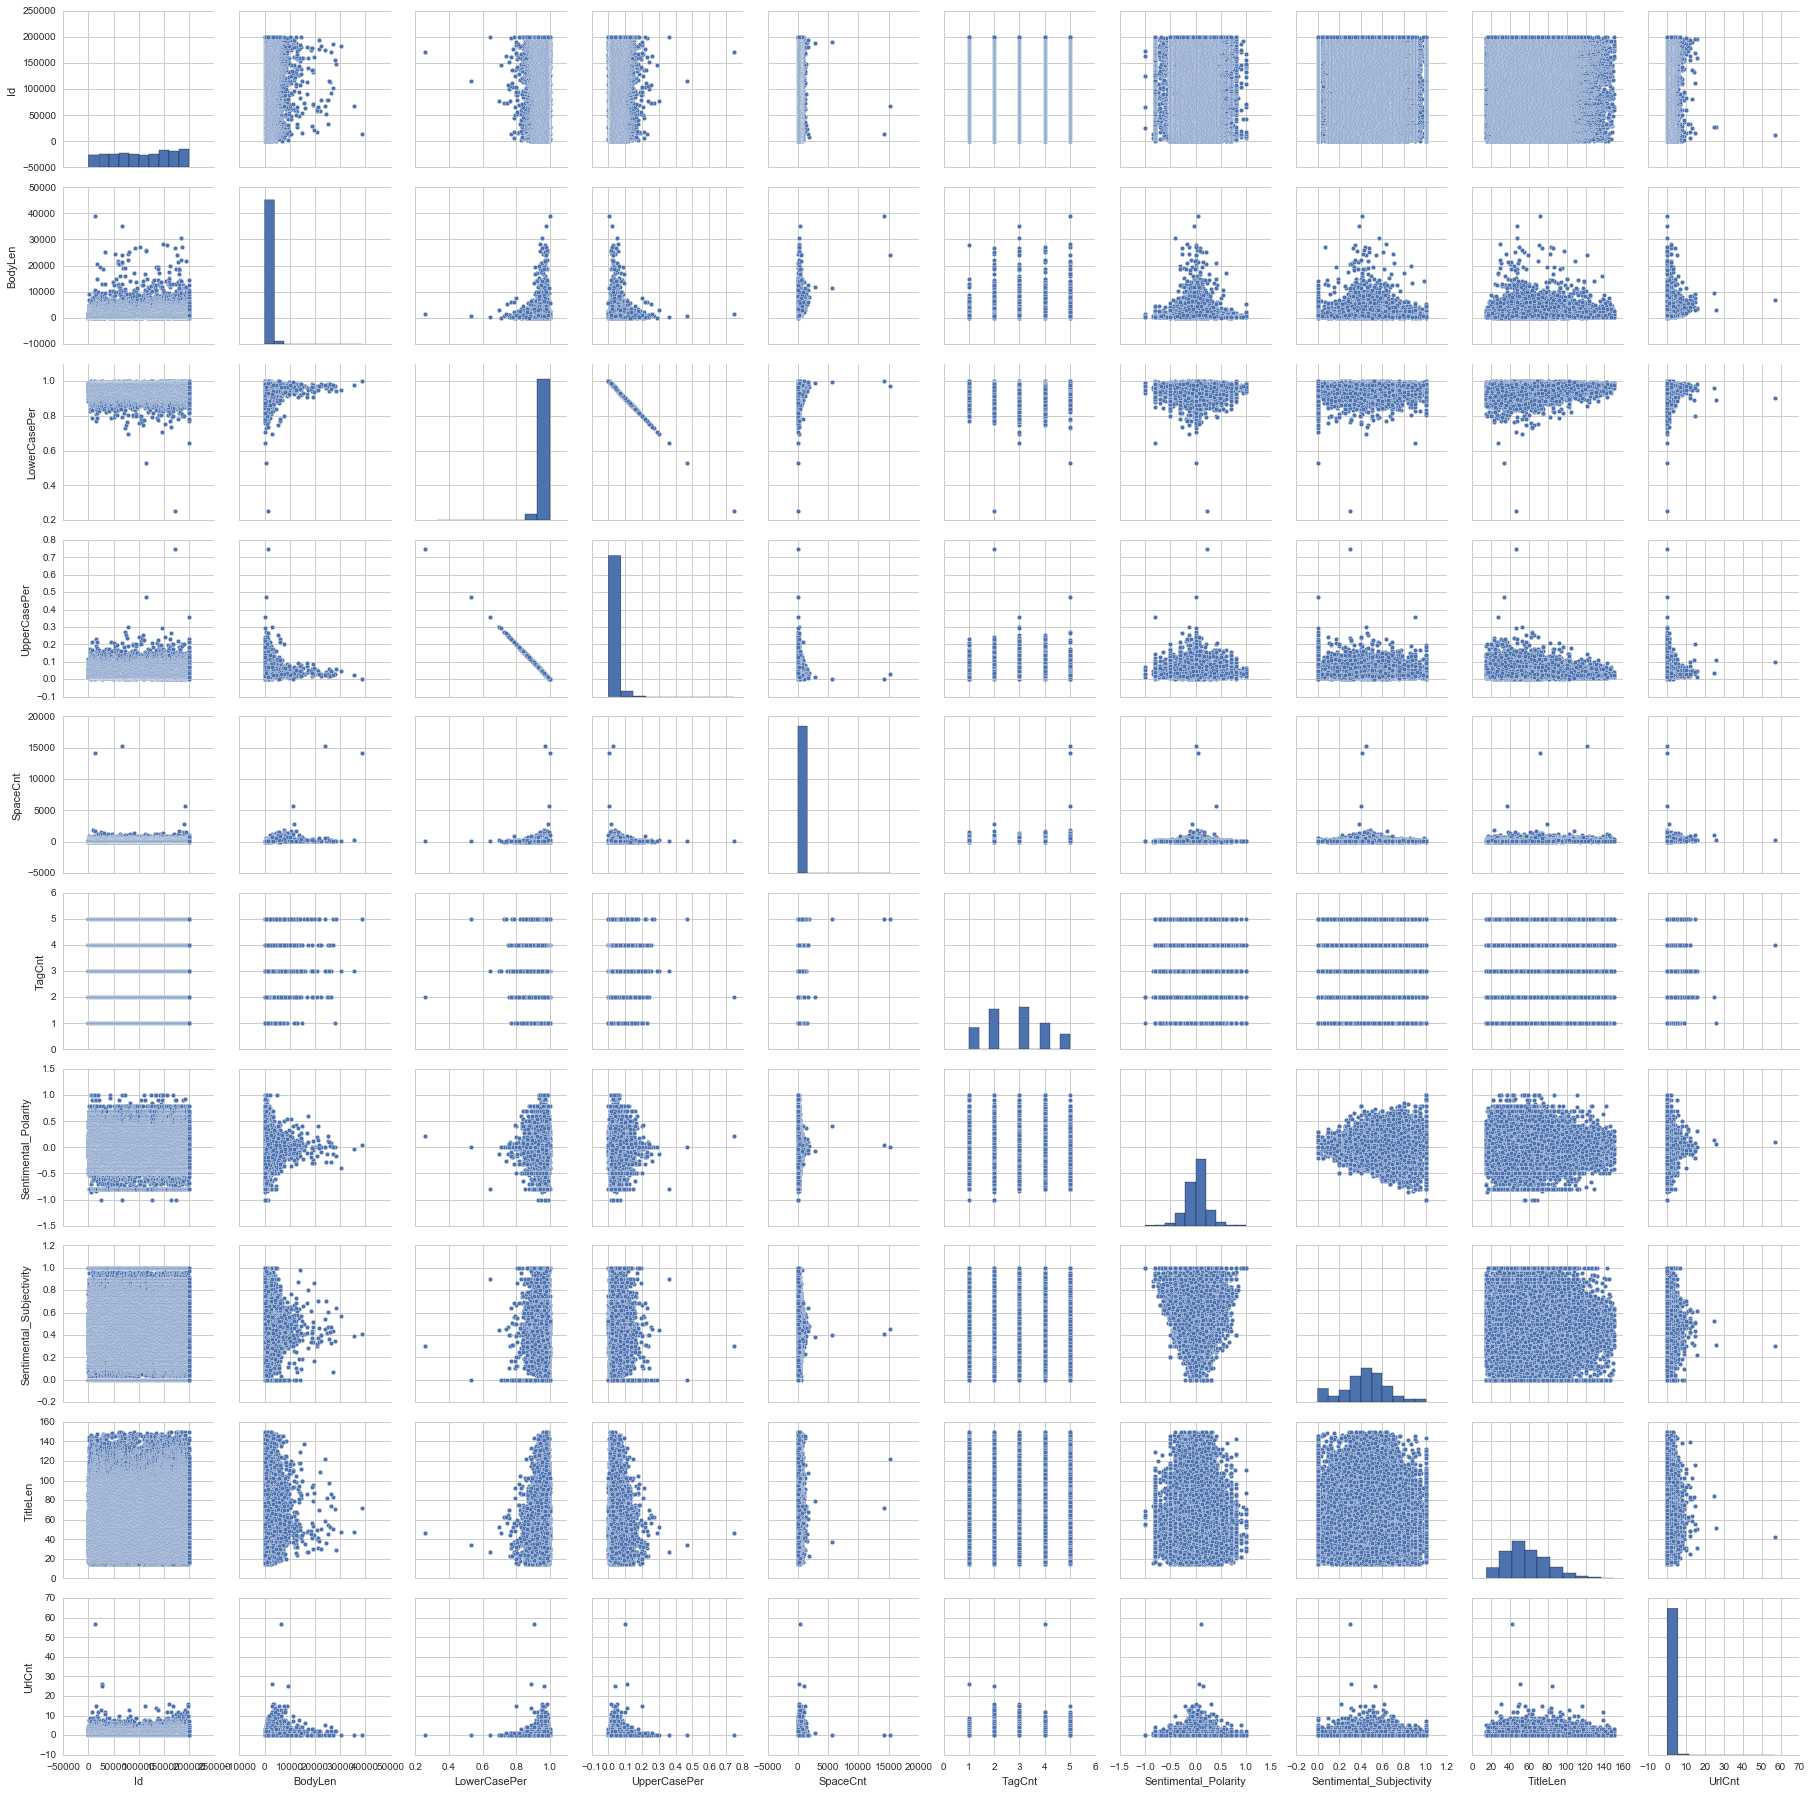

In [109]:
sns.pairplot(SOM[predictors_SOM])

## Readability Metrics

In [110]:
RM.head()

,Id,Code number,formula,word_count,sentence_count,ARI,CLI,FKG,FRE,GFI,M_Entropy,LOC_Per,Score
0,1,0.0,0.0,13,1,10.41,13.15,9.45,50.47,5.2,0.00613826,0.0,31
1,2,0.0,0.0,23,2,6.65,9.11,10.96,37,4.6,0.0036979,0.0,26
2,3,0.0,0.0,29,1,18.55,14.58,18.51,14.03,11.6,0.00275086,0.0,63
3,4,0.0,0.0,81,5,9.04,9.94,10.98,45.21,6.48,0.00110337,0.0,15
5,6,0.0,0.0,180,7,16.76,14.27,16.27,24.23,10.29,0.000372775,0.0,226


In [111]:
RM.shape

(75067, 13)

In [112]:
predictors_RM = [x for x in RM.columns if x not in ['Code number','formula', 'Body','Score']]

In [113]:
RM[predictors_RM].head()

,Id,word_count,sentence_count,ARI,CLI,FKG,FRE,GFI,M_Entropy,LOC_Per
0,1,13,1,10.41,13.15,9.45,50.47,5.2,0.00613826,0.0
1,2,23,2,6.65,9.11,10.96,37,4.6,0.0036979,0.0
2,3,29,1,18.55,14.58,18.51,14.03,11.6,0.00275086,0.0
3,4,81,5,9.04,9.94,10.98,45.21,6.48,0.00110337,0.0
5,6,180,7,16.76,14.27,16.27,24.23,10.29,0.000372775,0.0


In [114]:
#test=RM[(RM['word_count']>1000) & (RM['sentence_count']<100)].Body[2:3].tolist()[0]

In [115]:
#len(qpost_df[(RM['word_count']>500) & (RM['sentence_count']<100)].Body.tolist())

In [116]:
#new = RM[predictors_RM].dropna()
#new.head()

In [117]:
#sns.pairplot(new)

## Popularity Metrics

In [118]:
PM.head()

,Id,CreationDate,OwnerUserId,AccpAnsCnt,AppEditCnt,BadgeCnt,CloDelVCnt,UpVoteCnt,DownVoteCnt,FavVoteCnt,Score
0,1,2010-07-19 19:12:12.510,8.0,0,0,0,0,0,0,0,31
1,2,2010-07-19 19:12:57.157,24.0,0,0,0,0,0,0,0,26
2,3,2010-07-19 19:13:28.577,18.0,0,0,0,0,0,0,0,63
3,4,2010-07-19 19:13:31.617,23.0,0,0,0,0,0,0,0,15
4,6,2010-07-19 19:14:44.080,5.0,0,0,0,0,0,0,0,226


In [119]:
PM.shape

(75067, 11)

In [120]:
predictors_PM = [x for x in PM.columns if x not in ['CreationDate','OwnerUserId','Score']]
target = 'Score'

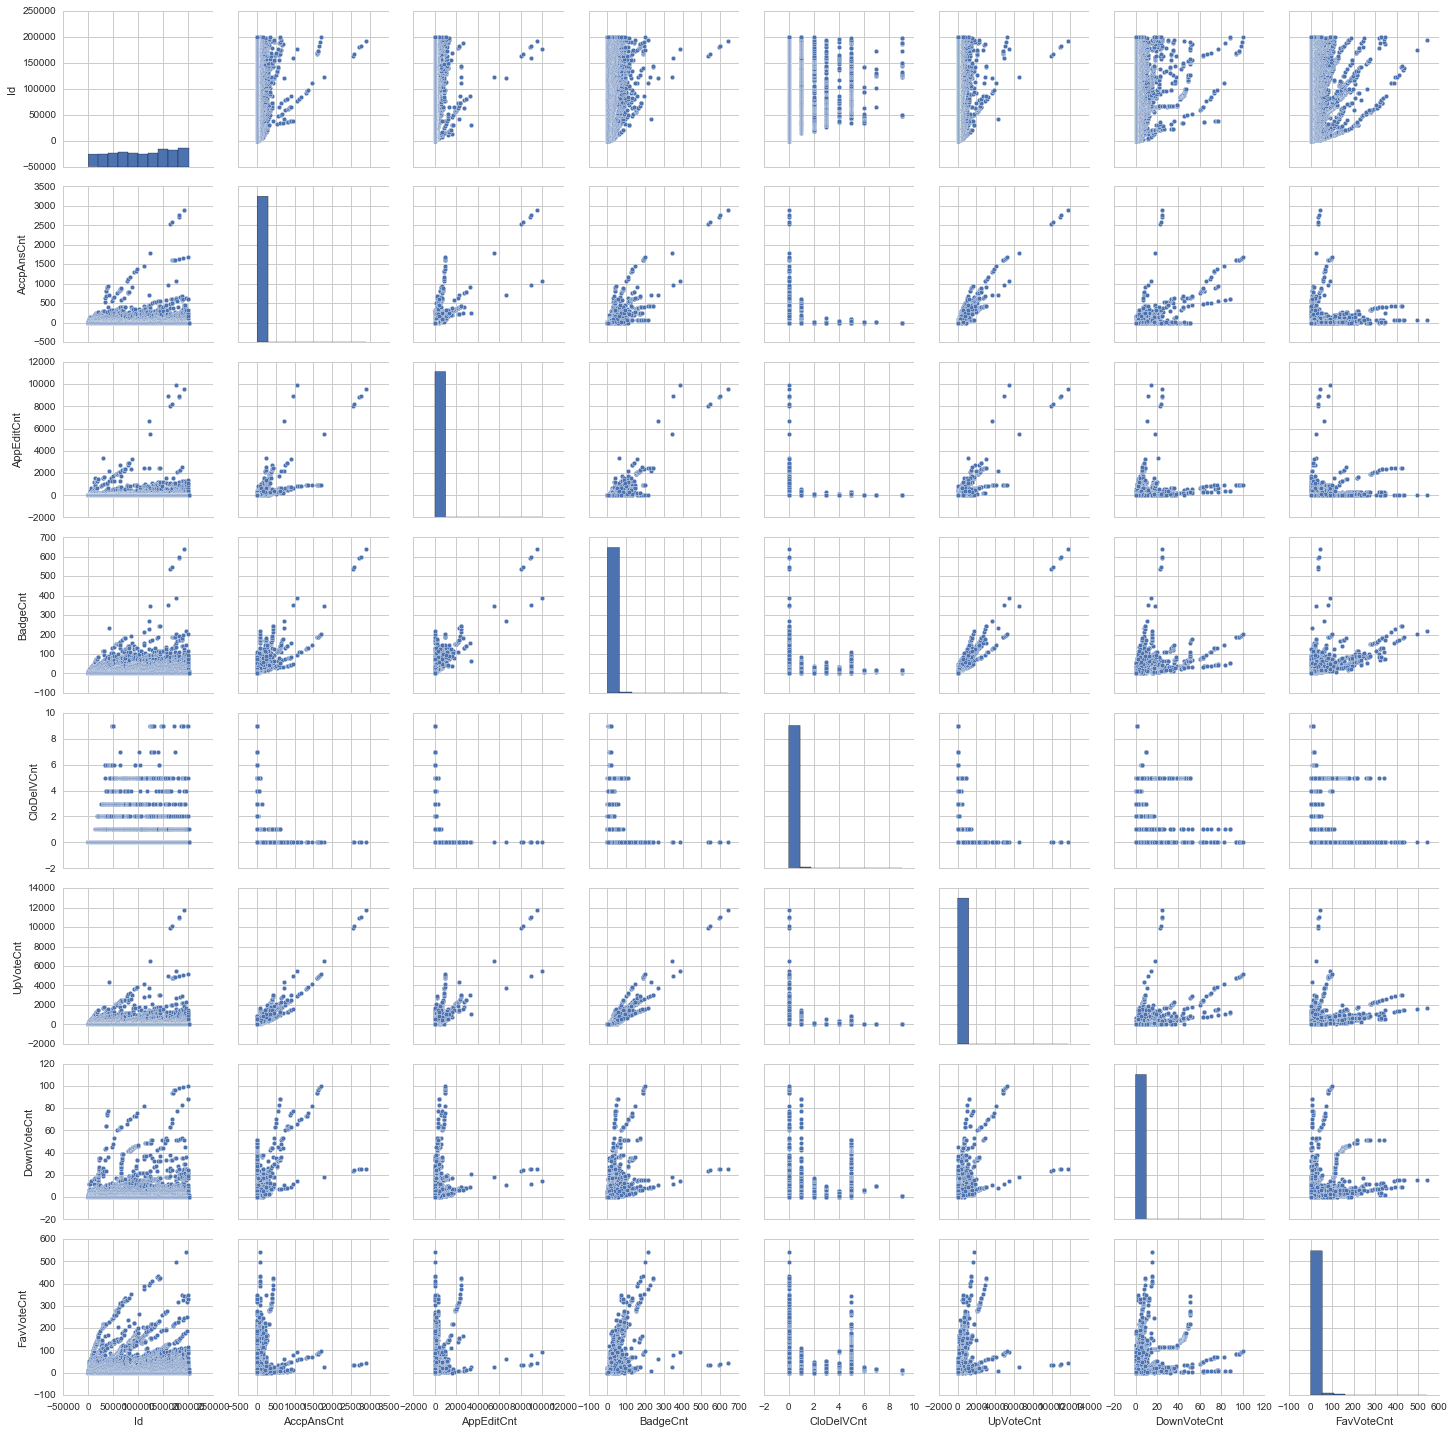

In [121]:
sns.pairplot(PM[predictors_PM])

In [122]:
dfs = [SOM[predictors_SOM],RM[predictors_RM],PM[predictors_PM],PM[['Id','Score']]]
data_SOQ = reduce(lambda left,right: pd.merge(left,right,on='Id'), dfs)

In [123]:
data_SOQ.shape, data_SOQ.columns

((75067, 27), Index([                      u'Id',                  u'BodyLen',
                    u'LowerCasePer',             u'UpperCasePer',
                        u'SpaceCnt',                   u'TagCnt',
            u'Sentimental_Polarity', u'Sentimental_Subjectivity',
                        u'TitleLen',                   u'UrlCnt',
                      u'word_count',           u'sentence_count',
                             u'ARI',                      u'CLI',
                             u'FKG',                      u'FRE',
                             u'GFI',                u'M_Entropy',
                         u'LOC_Per',               u'AccpAnsCnt',
                      u'AppEditCnt',                 u'BadgeCnt',
                      u'CloDelVCnt',                u'UpVoteCnt',
                     u'DownVoteCnt',               u'FavVoteCnt',
                           u'Score'],
       dtype='object'))

In [124]:
Class = []
def identify_class(row):
    if (row['Score']>=6) & (row['ClosedDate'] is None):
        Class.append(0)
    elif (row['Score']>=1) & (row['Score']<=5) & (row['ClosedDate']is None):
        Class.append(1)
    elif (row['Score']==0) & (row['ClosedDate']is None):
        Class.append(2)
    elif (row['Score']<0) & (row['ClosedDate']is None):
        Class.append(3)
    elif (row['ClosedDate']is not None):
        Class.append(4)

In [125]:
data_SOQ_class = qpost_df.apply(identify_class,axis=1)

In [126]:
Class_df = pd.Series(data=Class)
data_SOQ['Class'] = Class_df
data_SOQ['Class'].value_counts()

1    42336
2    21598
0     6933
4     3672
3      528
Name: Class, dtype: int64

In [127]:
Class_char = pd.Categorical.from_codes(data_SOQ['Class'], ['A','B','C','D','E'])
data_SOQ['Class_char'] = Class_char
data_SOQ=data_SOQ.replace('NA', np.nan)
data_SOQ=data_SOQ.replace('NaN', np.nan)
data_SOQ_rna = data_SOQ.dropna(axis=0, how='any')

In [128]:
data_SOQ.head(n=10)
target = 'Score'
Predictors = [x for x in data_SOQ.columns if x not in ['Id','Score','Class_char','Class']]
Predictors 

[u'BodyLen',
 u'LowerCasePer',
 u'UpperCasePer',
 u'SpaceCnt',
 u'TagCnt',
 u'Sentimental_Polarity',
 u'Sentimental_Subjectivity',
 u'TitleLen',
 u'UrlCnt',
 'word_count',
 'sentence_count',
 'ARI',
 'CLI',
 'FKG',
 'FRE',
 'GFI',
 'M_Entropy',
 'LOC_Per',
 'AccpAnsCnt',
 'AppEditCnt',
 'BadgeCnt',
 'CloDelVCnt',
 'UpVoteCnt',
 'DownVoteCnt',
 'FavVoteCnt']

In [131]:
import pickle
with open('data_SOQ_rna.pickle', 'wb') as handle:
    pickle.dump(data_SOQ_rna, handle,protocol=2)

In [67]:
data_SOQ_rna=pd.read_pickle('data_SOQ_rna.pickle')

In [120]:
data_SOQ_rna[Predictors].shape

(30772, 25)

# Modeling-- Random Forest

In [145]:
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_SOQ_rna, data_SOQ_rna['Class'], test_size=0.3,random_state=1,stratify=data_SOQ_rna['Class'])

In [146]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((21540, 29), (9232, 29), (21540,), (9232,))

In [147]:
train_y.value_counts(),  test_y.value_counts()

(1    13768
 0     3564
 2     3165
 4      865
 3      178
 Name: Class, dtype: int64, 1    5901
 0    1527
 2    1356
 4     371
 3      77
 Name: Class, dtype: int64)

In [148]:
from sklearn.ensemble import RandomForestClassifier

In [149]:
clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=1,oob_score = True)

In [150]:
clf.fit(train_x[Predictors], train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [151]:
clf.oob_score_, clf.feature_importances_

(0.63932219127205203,
 array([ 0.05846464,  0.05688897,  0.05679423,  0.05152129,  0.02484501,
         0.05792704,  0.05646218,  0.0589961 ,  0.01091949,  0.05092403,
         0.02516449,  0.05482648,  0.061371  ,  0.05390018,  0.05725993,
         0.05324831,  0.05826913,  0.02235093,  0.02010886,  0.02171983,
         0.02612966,  0.00319131,  0.03169898,  0.00912297,  0.01789497]))

In [76]:
#pd.crosstab(train_y, preds, rownames=['actual'], colnames=['preds'])

In [152]:
preds = clf.predict(test_x[Predictors])
metrics.accuracy_score(test_y, preds),
#print('ROC: %.2f' % (metrics.roc_auc_score(test_y, preds)))

(0.63864818024263437,)

In [153]:
pd.crosstab(test_y, preds, rownames=['actual'], colnames=['preds'])

preds,0,1,2,4
actual,,,,
0,55,1469,3,0
1,54,5833,12,2
2,2,1346,8,0
3,0,77,0,0
4,11,360,0,0


In [277]:
def plot_featureimportance(model_feature):
    feature_importance = pd.DataFrame(model_feature, index = Predictors)
    feature_importance = feature_importance.sort(0,ascending=False)
    #plt.figure(figsize=(10, 8))
    feature_importance.plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')
    plt.show()

/Users/RayLJazz/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


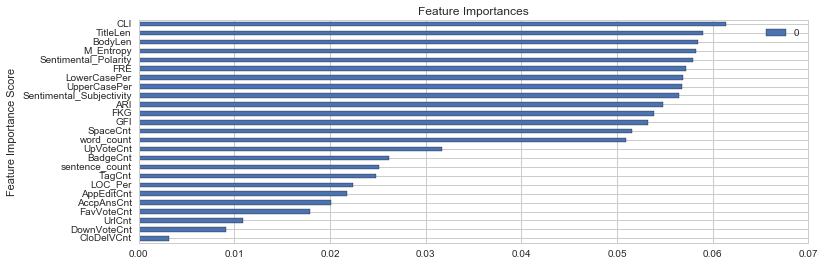

In [278]:
plot_featureimportance(clf.feature_importances_)

## Extreme Gradient Boosting

## Basic function

In [226]:
from xgboost.sklearn import XGBClassifier

In [227]:
train = train_x
train['Score'] = train_y
test = test_x
test['Score'] = test_y

/Users/RayLJazz/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/RayLJazz/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [228]:
train.shape, test.shape

((21540, 29), (9232, 29))

In [241]:
def modelfit(alg, dtrain, dtest, predictors,target, useTrainCV=True, cv_folds=5, early_stopping_round=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        xgb_param_forcv = xgb_param
        xgb_param_forcv['num_class'] = 5
        cvresult = xgb.cv(xgb_param_forcv, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             early_stopping_rounds=early_stopping_round, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='merror')
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    return alg, dtrain_predictions
   

In [253]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb1, dtrain_predictions = modelfit(xgb1, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 19


In [281]:
def get_performance(xgbmodel,dtrain,dtest,predictors,dtrain_predictions):
    print "\nModel Report"
    print "Train accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    test_result = xgbmodel.predict(dtest[predictors])
    print "Test accuracy : %.4g" % metrics.accuracy_score(dtest[target].values, test_result)
    
    feat_imp = pd.Series(xgbmodel.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')


Model Report
Train accuracy : 0.6476
Test accuracy : 0.6403


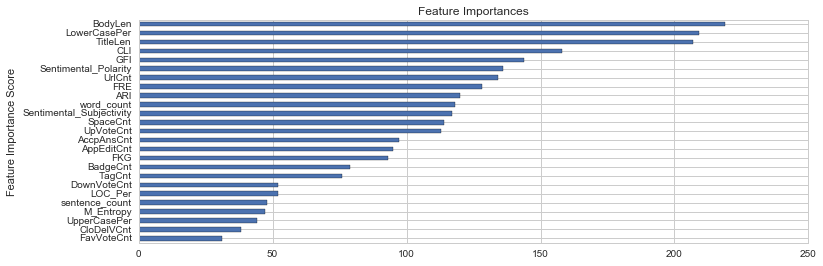

In [282]:
get_performance(xgb1,dtrain,dtest,Predictors,dtrain_predictions)